# Understanding SAE Features with the Logit Lens

This notebook demonstrates how to use the mats_sae_training library to perform the analysis documented the post "[Understanding SAE Features with the Logit Lens](https://www.alignmentforum.org/posts/qykrYY6rXXM7EEs8Q/understanding-sae-features-with-the-logit-lens)".

As such, the notebook will include sections for:

- Loading in GPT2-Small Residual Stream SAEs from Huggingface.
- Performing Virtual Weight Based Analysis of features (specifically looking at the logit weight distributions).
- Programmatically opening neuronpedia tabs to engage with public dashboards on [neuronpedia](https://www.neuronpedia.org/).
- Performing Token Set Enrichment Analysis (based on Gene Set Enrichment Analysis).


## Set Up

Here we'll load various functions for things like:

- downloading and loading our SAEs from huggingface.
- opening neuronpedia from a jupyter cell.
- calculating statistics of the logit weight distributions.
- performing Token Set Enrichment Analysis (TSEA) and plotting the results.


### Imports


In [1]:
from IPython import get_ipython  # type: ignore

ipython = get_ipython()
assert ipython is not None
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

In [2]:
# Feature statistics

import pandas as pd
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer

from sae_lens.sae import SAE


@torch.no_grad()
def get_feature_property_df(sae: SAE, feature_sparsity: torch.Tensor):
    """
    feature_property_df = get_feature_property_df(sae, log_feature_density.cpu())
    """

    W_dec_normalized = (
        sae.W_dec.cpu()
    )  # / sparse_autoencoder.W_dec.cpu().norm(dim=-1, keepdim=True)
    W_enc_normalized = (sae.W_enc.cpu() / sae.W_enc.cpu().norm(dim=-1, keepdim=True)).T

    d_e_projection = (W_dec_normalized * W_enc_normalized).sum(-1)
    b_dec_projection = sae.b_dec.cpu() @ W_dec_normalized.T

    return pd.DataFrame(
        {
            "log_feature_sparsity": feature_sparsity + 1e-10,
            "d_e_projection": d_e_projection,
            # "d_e_projection_normalized": d_e_projection_normalized,
            "b_enc": sae.b_enc.detach().cpu(),
            "b_dec_projection": b_dec_projection,
            "feature": list(range(sae.cfg.d_sae)),  # type: ignore
            "dead_neuron": (feature_sparsity < -9).cpu(),
        }
    )


@torch.no_grad()
def get_stats_df(projection: torch.Tensor):
    """
    Returns a dataframe with the mean, std, skewness and kurtosis of the projection
    """
    mean = projection.mean(dim=1, keepdim=True)
    diffs = projection - mean
    var = (diffs**2).mean(dim=1, keepdim=True)
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0), dim=1)
    kurtosis = torch.mean(torch.pow(zscores, 4.0), dim=1)

    return pd.DataFrame(
        {
            "feature": range(len(skews)),
            "mean": mean.numpy().squeeze(),
            "std": std.numpy().squeeze(),
            "skewness": skews.numpy(),
            "kurtosis": kurtosis.numpy(),
        }
    )


@torch.no_grad()
def get_all_stats_dfs(
    gpt2_small_sparse_autoencoders: dict[str, SAE],  # [hook_point, sae]
    gpt2_small_sae_sparsities: dict[str, torch.Tensor],  # [hook_point, sae]
    model: HookedTransformer,
    cosine_sim: bool = False,
):
    stats_dfs = []
    pbar = tqdm(gpt2_small_sparse_autoencoders.keys())
    for key in pbar:
        layer = int(key.split(".")[1])
        sparse_autoencoder = gpt2_small_sparse_autoencoders[key]
        pbar.set_description(f"Processing layer {sparse_autoencoder.cfg.hook_name}")
        W_U_stats_df_dec, _ = get_W_U_W_dec_stats_df(
            sparse_autoencoder.W_dec.cpu(), model, cosine_sim
        )
        log_feature_sparsity = gpt2_small_sae_sparsities[key].detach().cpu()
        W_U_stats_df_dec["log_feature_sparsity"] = log_feature_sparsity
        W_U_stats_df_dec["layer"] = layer + (1 if "post" in key else 0)
        stats_dfs.append(W_U_stats_df_dec)

    return pd.concat(stats_dfs, axis=0)


@torch.no_grad()
def get_W_U_W_dec_stats_df(
    W_dec: torch.Tensor, model: HookedTransformer, cosine_sim: bool = False
) -> tuple[pd.DataFrame, torch.Tensor]:
    W_U = model.W_U.detach().cpu()
    if cosine_sim:
        W_U = W_U / W_U.norm(dim=0, keepdim=True)
    dec_projection_onto_W_U = W_dec @ W_U
    W_U_stats_df = get_stats_df(dec_projection_onto_W_U)
    return W_U_stats_df, dec_projection_onto_W_U

/n/home04/cfang/.conda/envs/sae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import torch
import plotly_express as px

from transformer_lens import HookedTransformer

# Model Loading
from sae_lens import SAE
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

# Enrichment Analysis Functions
from tutorials.tsea import (
    get_enrichment_df,
    manhattan_plot_enrichment_scores,
    plot_top_k_feature_projections_by_token_and_category,
)
from tutorials.tsea import (
    get_baby_name_sets,
    get_letter_gene_sets,
    generate_pos_sets,
    get_test_gene_sets,
    get_gene_set_from_regex,
)

ModuleNotFoundError: No module named 'tutorials'

### Loading GPT2 Small and SAE Weights

This will take a while the first time you run it, but will be quick thereafter.


In [4]:
model = HookedTransformer.from_pretrained("gpt2-small")
# this is an outdated way to load the SAE. We need to have feature spartisity loadable through the new interface to remove it.
gpt2_small_sparse_autoencoders = {}
gpt2_small_sae_sparsities = {}

for layer in range(12):
    sae, original_cfg_dict, sparsity = SAE.from_pretrained(
        release="gpt2-small-res-jb",
        sae_id=f"blocks.{layer}.hook_resid_pre",
        device="cpu",
    )
    gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] = sae
    gpt2_small_sae_sparsities[f"blocks.{layer}.hook_resid_pre"] = sparsity

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model gpt2-small into HookedTransformer


/n/home04/cfang/.conda/envs/sae/lib/python3.12/site-packages/sae_lens/sae.py:146: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


# Statistical Properties of Feature Logit Distributions

In the post I study layer 8 (for no particular reason). At the end of this notebook is code for visualizing these statistics across all layers. Feel free to change the layer here and explore different layers.


In [5]:
# In the post, I focus on layer 8
layer = 8

# get the corresponding SAE and feature sparsities.
sparse_autoencoder = gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"]
log_feature_sparsity = gpt2_small_sae_sparsities[f"blocks.{layer}.hook_resid_pre"].cpu()

W_dec = sparse_autoencoder.W_dec.detach().cpu()

# calculate the statistics of the logit weight distributions
W_U_stats_df_dec, dec_projection_onto_W_U = get_W_U_W_dec_stats_df(
    W_dec, model, cosine_sim=False
)
W_U_stats_df_dec["sparsity"] = (
    log_feature_sparsity  # add feature sparsity since it is often interesting.
)
display(W_U_stats_df_dec)

,feature,mean,std,skewness,kurtosis,sparsity
0,0,1.518076e-10,0.147306,0.181176,3.349324,-2.826817
1,1,-1.157533e-08,0.167641,0.123870,3.466492,-3.049473
2,2,-2.890037e-08,0.157237,0.097977,3.300671,-2.960210
3,3,-1.518076e-10,0.174304,0.133900,3.522123,-2.822145
4,4,1.132864e-08,0.190366,0.212915,3.326519,-2.125533
...,...,...,...,...,...,...
24571,24571,1.408015e-08,0.205128,0.320509,3.330733,-1.933250
24572,24572,3.596891e-08,0.163037,0.112237,3.468480,-3.279720
24573,24573,2.743922e-08,0.166876,0.311090,4.092549,-2.592994
24574,24574,1.643317e-08,0.170027,0.359409,3.876930,-3.186663


In [7]:
W_U_stats_df_dec

,feature,mean,std,skewness,kurtosis,sparsity
0,0,1.518076e-10,0.147306,0.181176,3.349324,-2.826817
1,1,-1.157533e-08,0.167641,0.123870,3.466492,-3.049473
2,2,-2.890037e-08,0.157237,0.097977,3.300671,-2.960210
3,3,-1.518076e-10,0.174304,0.133900,3.522123,-2.822145
4,4,1.132864e-08,0.190366,0.212915,3.326519,-2.125533
...,...,...,...,...,...,...
24571,24571,1.408015e-08,0.205128,0.320509,3.330733,-1.933250
24572,24572,3.596891e-08,0.163037,0.112237,3.468480,-3.279720
24573,24573,2.743922e-08,0.166876,0.311090,4.092549,-2.592994
24574,24574,1.643317e-08,0.170027,0.359409,3.876930,-3.186663


In [8]:
import matplotlib.pyplot as plt

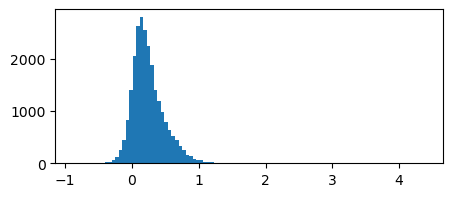

In [12]:
plt.figure(figsize=(5,2))
plt.hist(W_U_stats_df_dec['skewness'], bins=100)
plt.show()

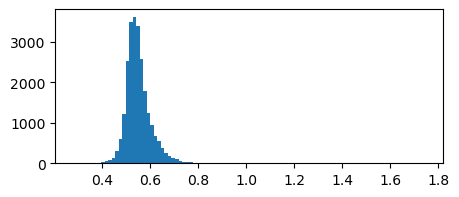

In [13]:
plt.figure(figsize=(5,2))
plt.hist(np.log10(W_U_stats_df_dec['kurtosis']), bins=100)
plt.show()

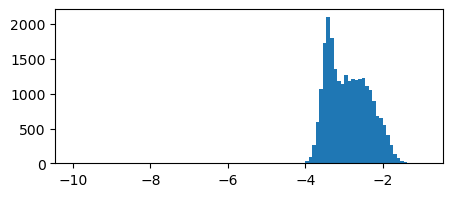

In [15]:
plt.figure(figsize=(5,2))
plt.hist(W_U_stats_df_dec['sparsity'], bins=100)
plt.show()

In [16]:
# then you can query accross combinations of the statistics to find features of interest and open them in neuronpedia.
tmp_df = W_U_stats_df_dec[["feature", "skewness", "kurtosis", "std"]]
# tmp_df = tmp_df[(tmp_df["std"] > 0.04)]
# tmp_df = tmp_df[(tmp_df["skewness"] > 0.65)]
tmp_df = tmp_df[(tmp_df["skewness"] > 3)]
tmp_df = tmp_df.sort_values("skewness", ascending=False).head(10)
display(tmp_df)

# if desired, open the features in neuronpedia
get_neuronpedia_quick_list(sparse_autoencoder, list(tmp_df.feature))

,feature,skewness,kurtosis,std
14215,14215,4.387646,55.515957,0.133079
19273,19273,3.638765,48.143673,0.115937
8992,8992,3.432152,44.810345,0.123028
895,895,3.228184,42.953152,0.112418


'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2214215%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2219273%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%228992%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%22895%22%7D%5D'

In [17]:
tmp_df.feature

14215    14215
19273    19273
8992      8992
895        895
Name: feature, dtype: int64

# Token Set Enrichment Analysis

We now proceed to token set enrichment analysis. I highly recommend reading my AlignmentForum post (espeically the case studies) before reading too much into any of these results.
Also read this [post](https://transformer-circuits.pub/2024/qualitative-essay/index.html) for good general perspectives on statistics here.


## Defining Our Token Sets


In [ ]:
import nltk

nltk.download("averaged_perceptron_tagger")
# get the vocab we need to filter to formulate token sets.
vocab = model.tokenizer.get_vocab()  # type: ignore

# make a regex dictionary to specify more sets.
regex_dict = {
    "starts_with_space": r"Ġ.*",
    "starts_with_capital": r"^Ġ*[A-Z].*",
    "starts_with_lower": r"^Ġ*[a-z].*",
    "all_digits": r"^Ġ*\d+$",
    "is_punctuation": r"^[^\w\s]+$",
    "contains_close_bracket": r".*\).*",
    "contains_open_bracket": r".*\(.*",
    "all_caps": r"Ġ*[A-Z]+$",
    "1 digit": r"Ġ*\d{1}$",
    "2 digits": r"Ġ*\d{2}$",
    "3 digits": r"Ġ*\d{3}$",
    "4 digits": r"Ġ*\d{4}$",
    "length_1": r"^Ġ*\w{1}$",
    "length_2": r"^Ġ*\w{2}$",
    "length_3": r"^Ġ*\w{3}$",
    "length_4": r"^Ġ*\w{4}$",
    "length_5": r"^Ġ*\w{5}$",
}

# print size of gene sets
all_token_sets = get_letter_gene_sets(vocab)
for key, value in regex_dict.items():
    gene_set = get_gene_set_from_regex(vocab, value)
    all_token_sets[key] = gene_set

# some other sets that can be interesting
baby_name_sets = get_baby_name_sets(vocab)
pos_sets = generate_pos_sets(vocab)
arbitrary_sets = get_test_gene_sets(model)

all_token_sets = {**all_token_sets, **pos_sets}
all_token_sets = {**all_token_sets, **arbitrary_sets}
all_token_sets = {**all_token_sets, **baby_name_sets}

# for each gene set, convert to string and  print the first 5 tokens
for token_set_name, gene_set in sorted(
    all_token_sets.items(), key=lambda x: len(x[1]), reverse=True
):
    tokens = [model.to_string(id) for id in list(gene_set)][:10]  # type: ignore
    print(f"{token_set_name}, has {len(gene_set)} genes")
    print(tokens)
    print("----")

## Performing Token Set Enrichment Analysis

Below we perform token set enrichment analysis on various token sets. In practice, we'd likely perform tests accross all tokens and large libraries of sets simultaneously but to make it easier to run, we look at features with higher skew and select of a few token sets at a time to consider.


In [ ]:
features_ordered_by_skew = (
    W_U_stats_df_dec["skewness"].sort_values(ascending=False).head(5000).index.to_list()
)

In [ ]:
# filter our list.
token_sets_index = [
    "starts_with_space",
    "starts_with_capital",
    "all_digits",
    "is_punctuation",
    "all_caps",
]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}

# calculate the enrichment scores
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U,  # use the logit weight values as our rankings over tokens.
    features_ordered_by_skew,  # subset by these features
    token_set_selected,  # use token_sets
)

manhattan_plot_enrichment_scores(
    df_enrichment_scores,
    label_threshold=0,
    top_n=3,  # use our enrichment scores
).show()

In [ ]:
fig = px.scatter(
    df_enrichment_scores.apply(lambda x: -1 * np.log(1 - x)).T,
    x="starts_with_space",
    y="starts_with_capital",
    marginal_x="histogram",
    marginal_y="histogram",
    labels={
        "starts_with_space": "Starts with Space",
        "starts_with_capital": "Starts with Capital",
    },
    title="Enrichment Scores for Starts with Space vs Starts with Capital",
    height=800,
    width=800,
)
# reduce point size on the scatter only
fig.update_traces(marker=dict(size=2), selector=dict(mode="markers"))
fig.show()

In [ ]:
token_sets_index = ["1 digit", "2 digits", "3 digits", "4 digits"]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores).show()

In [ ]:
token_sets_index = ["nltk_pos_PRP", "nltk_pos_VBZ", "nltk_pos_NNP"]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores).show()

In [ ]:
token_sets_index = ["nltk_pos_VBN", "nltk_pos_VBG", "nltk_pos_VB", "nltk_pos_VBD"]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores).show()

In [ ]:
token_sets_index = ["nltk_pos_WP", "nltk_pos_RBR", "nltk_pos_WDT", "nltk_pos_RB"]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores).show()

In [ ]:
token_sets_index = ["a", "e", "i", "o", "u"]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores).show()

In [ ]:
token_sets_index = ["negative_words", "positive_words"]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores).show()

In [ ]:
fig = px.scatter(
    df_enrichment_scores.apply(lambda x: -1 * np.log(1 - x))
    .T.reset_index()
    .rename(columns={"index": "feature"}),
    x="negative_words",
    y="positive_words",
    marginal_x="histogram",
    marginal_y="histogram",
    labels={
        "starts_with_space": "Starts with Space",
        "starts_with_capital": "Starts with Capital",
    },
    title="Enrichment Scores for Starts with Space vs Starts with Capital",
    height=800,
    width=800,
    hover_name="feature",
)
# reduce point size on the scatter only
fig.update_traces(marker=dict(size=2), selector=dict(mode="markers"))
fig.show()

In [ ]:
token_sets_index = ["contains_close_bracket", "contains_open_bracket"]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores).show()

In [ ]:
token_sets_index = [
    "1910's",
    "1920's",
    "1930's",
    "1940's",
    "1950's",
    "1960's",
    "1970's",
    "1980's",
    "1990's",
    "2000's",
    "2010's",
]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores).show()

In [ ]:
token_sets_index = ["positive_words", "negative_words"]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores, label_threshold=0.98).show()

In [ ]:
token_sets_index = ["boys_names", "girls_names"]
token_set_selected = {
    k: set(v) for k, v in all_token_sets.items() if k in token_sets_index
}
df_enrichment_scores = get_enrichment_df(
    dec_projection_onto_W_U, features_ordered_by_skew, token_set_selected
)
manhattan_plot_enrichment_scores(df_enrichment_scores).show()

In [ ]:
tmp_df = df_enrichment_scores.apply(lambda x: -1 * np.log(1 - x)).T
color = (
    W_U_stats_df_dec.sort_values("skewness", ascending=False)
    .head(5000)["skewness"]
    .values
)
fig = px.scatter(
    tmp_df.reset_index().rename(columns={"index": "feature"}),
    x="boys_names",
    y="girls_names",
    marginal_x="histogram",
    marginal_y="histogram",
    # color = color,
    labels={
        "boys_names": "Enrichment Score (Boys Names)",
        "girls_names": "Enrichment Score (Girls Names)",
    },
    height=600,
    width=800,
    hover_name="feature",
)
# reduce point size on the scatter only
fig.update_traces(marker=dict(size=3), selector=dict(mode="markers"))
# annotate any features where the absolute distance between boys names and girls names > 3
for feature in df_enrichment_scores.columns:
    if abs(tmp_df["boys_names"][feature] - tmp_df["girls_names"][feature]) > 2.9:
        fig.add_annotation(
            x=tmp_df["boys_names"][feature] - 0.4,
            y=tmp_df["girls_names"][feature] + 0.1,
            text=f"{feature}",
            showarrow=False,
        )


fig.show()

## Digging into Particular Features

When we do these enrichments, I generate the logit weight histograms by category using the following function. It's important to make sure the categories you group by are in the columns of df_enrichment_scores.


In [ ]:
for category in ["boys_names"]:
    plot_top_k_feature_projections_by_token_and_category(
        token_set_selected,
        df_enrichment_scores,
        category=category,
        dec_projection_onto_W_U=dec_projection_onto_W_U,
        model=model,
        log_y=False,
        histnorm=None,
    )

# Appendix Results: Logit Weight distribution Statistics Accross All Layers


In [ ]:
W_U_stats_df_dec_all_layers = get_all_stats_dfs(
    gpt2_small_sparse_autoencoders, gpt2_small_sae_sparsities, model, cosine_sim=True
)

display(W_U_stats_df_dec_all_layers.shape)
display(W_U_stats_df_dec_all_layers.head())

In [ ]:
# Let's plot the percentiles of the skewness and kurtosis by layer
tmp_df = W_U_stats_df_dec_all_layers.groupby("layer")["skewness"].describe(
    percentiles=[0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)
tmp_df = tmp_df[["1%", "5%", "10%", "25%", "50%", "75%", "90%", "95%", "99%"]]

fig = px.area(
    tmp_df,
    title="Skewness by Layer",
    width=800,
    height=600,
    color_discrete_sequence=px.colors.sequential.Turbo,
).show()


tmp_df = W_U_stats_df_dec_all_layers.groupby("layer")["kurtosis"].describe(
    percentiles=[0.01, 0.05, 0.10, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)
tmp_df = tmp_df[["1%", "5%", "10%", "25%", "50%", "75%", "90%", "95%", "99%"]]

fig = px.area(
    tmp_df,
    title="Kurtosis by Layer",
    width=800,
    height=600,
    color_discrete_sequence=px.colors.sequential.Turbo,
)

fig.show()

In [ ]:
# let's make a pretty color scheme
from plotly.colors import n_colors

colors = n_colors("rgb(5, 200, 200)", "rgb(200, 10, 10)", 13, colortype="rgb")

# Make a box plot of the skewness by layer
fig = px.box(
    W_U_stats_df_dec_all_layers,
    x="layer",
    y="skewness",
    color="layer",
    color_discrete_sequence=colors,
    height=600,
    width=1200,
    title="Skewness cos(W_U,W_dec) by Layer in GPT2 Small Residual Stream SAEs",
    labels={"layer": "Layer", "skewnss": "Skewness"},
)
fig.update_xaxes(showticklabels=True, dtick=1)

# increase font size
fig.update_layout(font=dict(size=16))
fig.show()

# Make a box plot of the skewness by layer
fig = px.box(
    W_U_stats_df_dec_all_layers,
    x="layer",
    y="kurtosis",
    color="layer",
    color_discrete_sequence=colors,
    height=600,
    width=1200,
    log_y=True,
    title="log kurtosis cos(W_U,W_dec) by Layer in GPT2 Small Residual Stream SAEs",
    labels={"layer": "Layer", "kurtosis": "Log Kurtosis"},
)
fig.update_xaxes(showticklabels=True, dtick=1)

# increase font size
fig.update_layout(font=dict(size=16))
fig.show()

In [ ]:
# scatter
fig = px.scatter(
    W_U_stats_df_dec_all_layers[W_U_stats_df_dec_all_layers.log_feature_sparsity >= -9],
    # W_U_stats_df_dec_all_layers[W_U_stats_df_dec_all_layers.layer == 8],
    x="skewness",
    y="kurtosis",
    color="std",
    color_continuous_scale="Portland",
    hover_name="feature",
    # color_continuous_midpoint = 0,
    # range_color = [-4,-1],
    log_y=True,
    height=800,
    # width = 2000,
    # facet_col="layer",
    # facet_col_wrap=5,
    animation_frame="layer",
)
fig.update_yaxes(matches=None)
fig.for_each_yaxis(lambda yaxis: yaxis.update(showticklabels=True))

# decrease point size
fig.update_traces(marker=dict(size=5))
fig.show()
fig.write_html("skewness_kurtosis_scatter_all_layers.html")